## Classification supervisée des images

Un réseau de neurones est-il en mesure de détecter les armures des tissages ?

In [36]:
import pandas as pd
import os
import numpy as np
import shutil #copier fichier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import random


In [5]:
data = '../data'

In [6]:
os.chdir(data)

In [7]:
from ultralytics import YOLO

### Création du dataset

In [8]:
#CREATION DOSSIER D'IMAGES VRAIES
def copy_random_images(source_dir, dest_dir, num_images):
    # Vérification et création du dossier de destination
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Liste des images dans le dossier source
    images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Vérification du nombre d'images disponibles
    if len(images) < num_images:
        raise ValueError("Le dossier source ne contient pas suffisamment d'images.")

    # Sélection aléatoire des images
    selected_images = random.sample(images, num_images)

    # Copier les images sélectionnées vers le dossier de destination
    for image in selected_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(dest_dir, image)
        shutil.copyfile(src_path, dst_path)

In [13]:
# Exemple d'utilisation
source_dir = 'dataset_double'
dest_dir = 'yolo/vrai'
copy_random_images(source_dir, dest_dir, 212)

In [14]:
def split_and_save_images(source_dir):
    for image_name in os.listdir(source_dir):
        image_path = os.path.join(source_dir, image_name)
        
        if os.path.isfile(image_path) and image_name.lower().endswith('.jpg'):
            with Image.open(image_path) as img:
                width, height = img.size
                img_sat = img.crop((0, 0, width // 2, height))

                # Sauvegarder les deux moitiés en écrasant l'image originale
                img_sat.save(image_path)

In [16]:
# Exemple d'utilisation
split_and_save_images('yolo/vrai')

### Téléchargement du modèle et visualisation de ses composantes

In [17]:
#Version YOLOv8
model = YOLO('yolov8n-cls')

100%|██████████████████████████████████████| 5.30M/5.30M [00:01<00:00, 4.68MB/s]


In [18]:
#Version YOLOv8
model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

### Partage des données train/test

In [19]:
yolo = "yolo"
os.makedirs(yolo, exist_ok=True)

In [20]:
dataset_dir = data
train_dir = 'yolo/train'
val_dir = 'yolo/val'

In [21]:
faux_test = "GAN/predicted_images106_test"
faux_val = "GAN/predicted_images106_val"
faux_dir = 'yolo/faux'
os.makedirs(faux_dir, exist_ok=True)

In [22]:
# Create the destination folder if it doesn't exist
if not os.path.exists(faux_dir):
    os.makedirs(faux_dir)

# Copy the contents of the first folder to the destination folder
for item in os.listdir(faux_test):
    source_path = os.path.join(faux_test, item)
    destination_path = os.path.join(faux_dir, item)
    if os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
    else:
        shutil.copy2(source_path, destination_path)

# Copy the contents of the second folder to the destination folder
for item in os.listdir(faux_val):
    source_path = os.path.join(faux_val, item)
    destination_path = os.path.join(faux_dir, f"V_{item}")
    if os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
    else:
        shutil.copy2(source_path, destination_path)

In [23]:
class_folders = [dir for dir in os.listdir(yolo) if os.path.isdir(os.path.join(yolo, dir))]
#On récupère la listes des noms des dossiers/classes

In [24]:
class_folders

['vrai', 'faux']

### Entraînement des données

In [26]:
for original_folder in class_folders:
  if original_folder == "vrai" or original_folder == "faux":

    old_path  = os.path.join(yolo, original_folder) #concaténation chemin et nom du dossier
    new_folder_name = original_folder.split('-')[0]
    new_path = os.path.join(yolo, new_folder_name) #creation nouveau chemin

    os.rename(old_path, new_path)

In [27]:
#Pour répartir les images d'entraînement et de validation dans des dossiers avec le bon nom
for class_folder in class_folders:
    if class_folder == "vrai" or class_folder == "faux":

      class_path = os.path.join(yolo, class_folder)
      images = [image for image in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, image))]

      train_img, val_img = train_test_split(images, test_size=0.2, random_state=42)

      train_subfolder_path = os.path.join(train_dir, class_folder)
      val_subfolder_path = os.path.join(val_dir, class_folder)

      os.makedirs(train_subfolder_path, exist_ok=True)
      os.makedirs(val_subfolder_path, exist_ok=True)

      for img in train_img:
        shutil.copy(os.path.join(class_path, img), train_subfolder_path)

      for img in val_img:
        shutil.copy(os.path.join(class_path, img), val_subfolder_path)

In [37]:
###### Version pour YOLOv8
results = model.train(data='yolo',
                      epochs=10,
                      batch=32,
                      dropout=0.1,
                      seed = 42)
                     ,#device='mps') #Entrainement sur la puce Apple M2 (et M1) "Metal Performance Shaders"

#Bug. en utilisant MPS: error: 'mps.select' op failed to verify that all of {true_value, false_value, result} have same element type
    # note: see current operation: %17 = "mps.select"(%16, %15, %14) : (tensor<1xi1>, tensor<1xf16>, tensor<1xf32>) -> tensor<1xf16>
    #failed assertion 'expected a valid model URL'
#Pas encore solutionné par Ultralytics : https://github.com/ultralytics/ultralytics/issues/7554 (issue du 13 janvier 2024).

New https://pypi.org/project/ultralytics/8.2.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.18 🚀 Python-3.11.9 torch-2.2.2 CPU (Apple M2)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/Users/lise/Python/projet/data/yolo, epochs=10, time=None, patience=100, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
train: Scanning /Users/lise/Python/projet/data/yolo/train... 338 images, 0 corru

train: New cache created: /Users/lise/Python/projet/data/yolo/train.cache



val: Scanning /Users/lise/Python/projet/data/yolo/val... 86 images, 0 corrupt: 1

val: New cache created: /Users/lise/Python/projet/data/yolo/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train4
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10         0G     0.7101         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all      0.512          1



      Epoch    GPU_mem       loss  Instances       Size


       2/10         0G     0.5721         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


       3/10         0G     0.3929         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


       4/10         0G     0.2313         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


       5/10         0G     0.1407         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


       6/10         0G    0.09458         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


       7/10         0G    0.08137         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


       8/10         0G    0.05429         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


       9/10         0G    0.05722         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G    0.05257         18        224: 100%|██████████| 11/11 
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,

                   all          1          1



10 epochs completed in 0.057 hours.
Optimizer stripped from runs/classify/train4/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train4/weights/best.pt, 3.0MB

Validating runs/classify/train4/weights/best.pt...
Ultralytics YOLOv8.2.18 🚀 Python-3.11.9 torch-2.2.2 CPU (Apple M2)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/lise/Python/projet/data/yolo/train... found 338 images in 2 classes ✅ 
val: /Users/lise/Python/projet/data/yolo/val... found 86 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,


                   all          1          1
Speed: 0.0ms preprocess, 8.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train4
Results saved to runs/classify/train4


In [28]:
my_model = YOLO('runs/classify/train4/weights/best.pt')

In [30]:
#Visualisation des résultats du modèle = résultat
result = my_model('yolo/val/faux/predicted_image_40.png', visualize=True, save=True)
#En jaune on voir les zones maximisées par neurones (pooling = plus on avance dans les couches moins on a de pixels)
#Intéressant pour comprendre les choix de classification d'un réseau (couleur, motif, background...)


Saving runs/classify/predict3/predicted_image_40/stage0_Conv_features.png... (16/16)
Saving runs/classify/predict3/predicted_image_40/stage1_Conv_features.png... (32/32)
Saving runs/classify/predict3/predicted_image_40/stage2_C2f_features.png... (32/32)
Saving runs/classify/predict3/predicted_image_40/stage3_Conv_features.png... (32/64)
Saving runs/classify/predict3/predicted_image_40/stage4_C2f_features.png... (32/64)
Saving runs/classify/predict3/predicted_image_40/stage5_Conv_features.png... (32/128)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Saving runs/classify/predict3/predicted_image_40/stage6_C2f_features.png... (32/128)
Saving runs/classify/predict3/predicted_image_40/stage7_Conv_features.png... (32/256)
Saving runs/classify/predict3/predicted_image_40/stage8_C2f_features.png... (32/256)
image 1/1 /Users/lise/Python/GAN-satellite-project/data/yolo/val/faux/predicted_image_40.png: 224x224 faux 1.00, vrai 0.00, 12648.2ms
Speed: 64.9ms preprocess, 12648.2ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 224)
Results saved to runs/classify/predict3


### Tentative de compréhension des _features_
Méthode de l'occlusion.

In [31]:
occlusion = "yolo/occlusion"
os.makedirs(occlusion, exist_ok=True)

In [32]:
def generate_occlusion(image, model, class_id,occlusion_size,step_size):
    #initialisation des valeurs
    image_height, image_width , _ = image.shape
    heatmap=np.zeros((image_height,image_width))
    
    predict_model=YOLO(model)
    results=predict_model.predict(image)

    #YOLO me sort 4 informations top1 id , top1conf, top5 id , top5conf. 
    #Il faut s'assurer que la classe id est dans le top 1 et dans le cas échéant ou dans le top5 (avec la proba associée)

    if class_id in results[0].probs.top5 :
        rank = results[0].probs.top5.index(class_id)
        initial_confidence=results[0].probs.top5conf[rank]
    else : 
        initial_confidence=0
    

    for y in range(0,image_width - occlusion_size[1] + 1, step_size) : #on oublie pas de commencer à 0, à cause du pas
        for x in range(0,image_height - occlusion_size[0] + 1, step_size) : 
            print(y,x) #Permet de voir l'avancée de l'occlusion
            
            occluded_image=image.copy()
            occluded_image[x:x + occlusion_size[0],y:y + occlusion_size[1]] = 0 

            results=predict_model.predict(occluded_image)

            if class_id in results[0].probs.top5 :
                rank = results[0].probs.top5.index(class_id)
                class_confidence=results[0].probs.top5conf[rank]
            else : 
                class_confidence = 0

            heatmap[x:x + occlusion_size[0],y:y + occlusion_size[1]] = initial_confidence - class_confidence

    heatmap=(heatmap-np.min(heatmap)/np.max(heatmap) - np.min(heatmap))

    return heatmap

In [43]:
def get_random_image(source_dir, num_images):
    
    # Liste des images dans le dossier source
    images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Vérification du nombre d'images disponibles
    if len(images) < num_images:
        raise ValueError("Le dossier source ne contient pas suffisamment d'images.")

    # Sélection aléatoire des images
    selected_images = random.sample(images, num_images)

    list_path = []

    for im in selected_images :
        list_path.append(os.path.join(source_dir, im))
        
    return list_path

In [17]:
get_random_image('yolo/val/faux/',5)

['/Users/lise/Python/projet/data/yolo/val/faux/predicted_image_51.png',
 '/Users/lise/Python/projet/data/yolo/val/faux/predicted_image_63.png',
 '/Users/lise/Python/projet/data/yolo/val/faux/predicted_image_40.png',
 '/Users/lise/Python/projet/data/yolo/val/faux/V_predicted_image_48.png',
 '/Users/lise/Python/projet/data/yolo/val/faux/predicted_image_76.png']

In [ ]:
for image_path in get_random_image('yolo/val/faux/', 5) : 
    image=cv2.imread(image_path,cv2.IMREAD_COLOR)
    heatmap=generate_occlusion(image,'runs/classify/train4/weights/best.pt',0,(5,5),5)
    overlay_image=overlay_heatmap(image,heatmap)
    cv2.imwrite(f'occlusion/occlusion_{image_path.split("/")[-1]}',overlay_image)


0: 224x224 faux 1.00, vrai 0.00, 98.2ms
Speed: 79.5ms preprocess, 98.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
0 0

0: 224x224 faux 1.00, vrai 0.00, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0 5

0: 224x224 faux 1.00, vrai 0.00, 20.0ms
Speed: 3.4ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0 10

0: 224x224 faux 1.00, vrai 0.00, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0 15

0: 224x224 faux 1.00, vrai 0.00, 16.3ms
Speed: 3.1ms preprocess, 16.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0 20

0: 224x224 faux 1.00, vrai 0.00, 16.9ms
Speed: 2.9ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0 25

0: 224x224 faux 1.00, vrai 0.00, 15.6ms
Speed: 2.4ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0 30


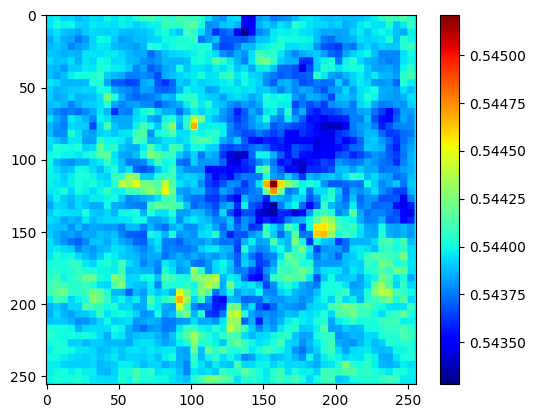

In [38]:
plt.imshow(heatmap,cmap='jet')
plt.colorbar()
plt.show()

In [39]:
def overlay_heatmap(image,heatmap,alpha=0.5) :
    heatmap_normalize = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap_colored=cv2.applyColorMap(np.uint8(255*heatmap_normalize),cv2.COLORMAP_JET)
    
    overlay=cv2.addWeighted(image,alpha,heatmap_colored,1-alpha,0)
    return overlay

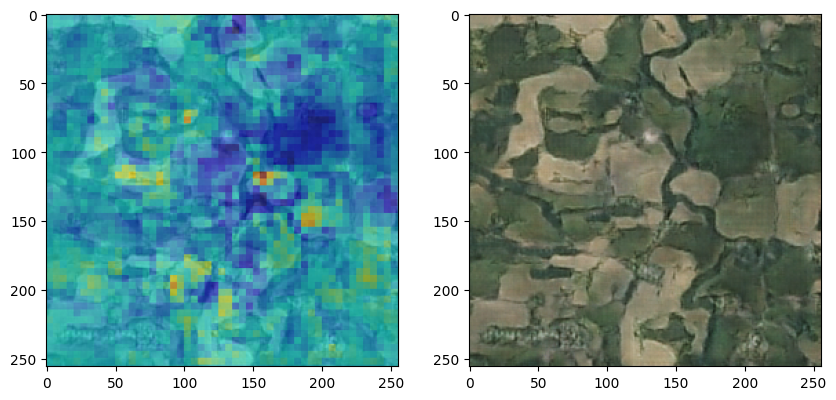

In [40]:
f, axes = plt.subplots(1,2, figsize=(10,15))
overlay_image=overlay_heatmap(image,heatmap)
axes[0].imshow(cv2.cvtColor(overlay_image,cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

plt.show()

In [42]:
cv2.imwrite(f'yolo/occlusion/occlusion_{image_path.split("/")[-1]}',overlay_image)

True